In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import pickle
import json
import cv2
import re
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = 'mmhs150k/'
model_dir = 'models/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

In [4]:
# load pretrained LSTM and CNN for text and images
from keras.models import load_model

lstm = load_model(model_dir + 'lstm.h5')
cnn = load_model(model_dir + 'cnn.h5')

print(lstm.summary())
print(cnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           7565100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 7,715,851
Trainable params: 150,751
Non-trainable params: 7,565,100
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
___________

In [5]:
# create new models that are all but the last layer
from keras.models import Sequential, Model

text_net = Sequential()
for layer in lstm.layers[:-1]: text_net.add(layer)
print(text_net.summary())

img_net = Sequential()
for layer in cnn.layers[:-3]: img_net.add(layer)
print(img_net.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           7565100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               150600    
Total params: 7,715,700
Trainable params: 150,600
Non-trainable params: 7,565,100
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
____________________________________________________________

In [6]:
# build full FCM model using concatenation layer
from keras.layers.merge import concatenate
from keras.layers import Dense, Input
from keras.optimizers import Adam

text_input = Input((text_net.layers[0].input_shape[-1],)) # get rid of None's in front
img_text_input = Input((text_net.layers[0].input_shape[-1],))
img_input = Input((img_net.layers[0].input_shape[1:])) # get rid of None in front

text_embed = text_net(text_input)
img_text_embed = text_net(img_text_input)
img_embed = img_net(img_input)

x = concatenate([text_embed, img_text_embed, img_embed])
# x = Dense(2048 + 150 + 150, activation='relu')(x)
# x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

fcm_model = Model(inputs=[text_input, img_text_input, img_input], outputs=prediction)
print(fcm_model.summary())

optimizer = Adam(lr = 0.001)
fcm_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 150)          7715700     input_1[0][0]                    
                                                                 input_2[0][0]              

In [7]:
# method for cleaning text like in https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
def hashtag(text):
    hashtag_body = text.group()[1:]
    if hashtag_body.isupper(): return "<hashtag> {} ".format(hashtag_body.lower())
    else: return ' '.join(["<hashtag>"] + [re.sub(r"([A-Z])",r" \1", hashtag_body, flags=re.MULTILINE | re.DOTALL)])

def allcaps(text): return text.group().lower() + ' <allcaps> '    

def clean_tweet_text(t):
    eyes = r'[8:=;]'
    nose = r"['`\-]?"
    
    t = re.sub(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', '<url>', t)
    t = re.sub(r'@\w+', '<user>', t)
    t = re.sub(r'{}{}[)dD]+|[)dD]+{}{}'.format(eyes, nose, nose, eyes), '<smile>', t)
    t = re.sub(r'{}{}p+".format(eyes, nose)', '<lolface>', t)
    t = re.sub(r'{}{}\(+|\)+{}{}'.format(eyes, nose, nose, eyes), '<sadface>', t)
    t = re.sub(r'{}{}[\/|l*]'.format(eyes, nose), '<neutralface>', t)
    t = re.sub(r'/', ' / ', t)
    t = re.sub(r'<3','<heart>', t)
    t = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '<number>', t)
    t = re.sub(r'#\S+', hashtag, t)
    t = re.sub(r'([!?.]){2,}', r'\1 <repeat>', t)
    t = re.sub(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 <elong>', t)
    t = re.sub(r'([A-Z]){2,}', allcaps, t)
    t = re.sub(r'{}'.format(r'[\".,-;&:]'), ' ', t)
    return t.lower()

In [8]:
# custom data generator to handle multimodal data
from random import randint # for random cropping
from keras.preprocessing.sequence import pad_sequences

pad_len = text_net.layers[0].input_shape[-1]
class MMDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, splits_path, tweet_dict, tokenizer, pad_len, batch_size=32, dim=(299, 299), n_channels=3, 
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.tweet_dict = tweet_dict
        self.tokenizer = tokenizer
        self.pad_len = pad_len
        
        # build labels list and id list
        self.id_list = open(splits_path, 'r').read().splitlines()
        self.labels = dict()
        for id in self.id_list:
            binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
            label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0
            self.labels[id] = label
        
        # create dictionary for embedded sequences (tuple of text and img_text)
        self.text_dict = self.process_text(self.id_list)
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X_txt, X_img_txt, X_img, y = self.__data_generation(id_list_temp)
        
#         print(X_txt.shape, X_img_txt.shape, X_img.shape, y.shape)
        return [X_txt, X_img_txt, X_img], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        X_txt = np.empty((len(id_list_temp), self.pad_len))
        X_img_txt = np.empty((len(id_list_temp), self.pad_len))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            X_img[i,] = self.process_img(data_dir + 'img_resized/' + ID + '.jpg')
            X_txt[i,] = self.text_dict[ID][0]
            X_img_txt[i,] = self.text_dict[ID][1]

            # Store class
            y[i] = self.labels[ID]

        return X_txt, X_img_txt, X_img, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data)
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        
        return im
    
    def get_labels(self): # get list of labels for calculating AUROC
        return [self.labels[ID] for ID in self.id_list]
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im
    
    def process_text(self, id_list):
        
        # matrix for texts
        texts = [clean_tweet_text(tweet_dict[ID]['tweet_text']) for ID in id_list]
        sequences = self.tokenizer.texts_to_sequences(texts)
        text_seqs = pad_sequences(sequences, maxlen=self.pad_len)
        
        # matrix for img_texts
        img_texts = []
        for ID in id_list:
            if os.path.exists(data_dir + 'img_txt/' + ID + '.json'):
                img_txt = json.load(open(data_dir + 'img_txt/' + ID + '.json', 'r'))['img_text']
                img_texts.append(img_txt)
            else: img_texts.append('')
        img_txt_sequences = self.tokenizer.texts_to_sequences(img_texts)
        img_text_seqs = pad_sequences(img_txt_sequences, maxlen=self.pad_len) 
        
        
        id_to_seq = dict() # map id to text sequence compatible with embedding layer
        for ID, txt, img_txt in zip(id_list, text_seqs, img_text_seqs):
            id_to_seq[ID] = (txt, img_txt)
        
        return id_to_seq

In [14]:
# create data generators
tokenizer = pickle.load(open(model_dir + 'tokenizer.pkl', 'rb'))
pad_len = text_net.layers[0].input_shape[-1]

train_gen = MMDataGenerator(splits_path=data_dir + 'splits/train_ids.txt',
                          tweet_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=True)

val_gen = MMDataGenerator(splits_path=data_dir + 'splits/val_ids.txt',
                          tweet_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=True)

test_gen = MMDataGenerator(splits_path=data_dir + 'splits/test_ids.txt',
                          tweet_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=True)

In [10]:
# train model
history = fcm_model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=1)

Epoch 1/1
4214/4214 [==============================] - 10089s 2s/step - loss: 0.4729 - accuracy: 0.7959 - val_loss: 1.3270 - val_accuracy: 0.5884


In [13]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import math

y_test = test_gen.get_labels()

# get AUROC
preds = fcm_model.predict_generator(test_gen)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
print('Test acc:', fcm_model.evaluate(test_gen)[1])

# get F1
preds_bin = np.array(preds)
preds_bin[preds>0.5] = 1
preds_bin[preds<=0.5] = 0
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.50704354
313/313 [==============================] - 206s 659ms/step
Test acc: 0.5835999846458435
Test F1: 0.21644479248238058
Test Precision: 0.49891696750902526
Test Recall: 0.1382


1057393737372966912
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.3850e+03 4.5000e+01 3.0000e+00 1.0754e+04 4.0000e+00
 2.6780e+03 1.0000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


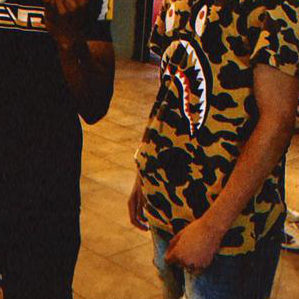

label: 0 



1057149180148240384
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
 1.220e+02 2.258e+03 6.000e+01 6.700e+01 1.000e+01 5.485e+03 2.010e+02
 1.000e+00]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.1640e+03 8.2800e+02
 2.3300e+02 5.5740e+03 1.6080e+03 1.3100e+02 8.0000e+00 1.4100e+02
 2.9000e+01 6.8300e+02 2.6000e+01 6.5500e+02 1.4000e+01 

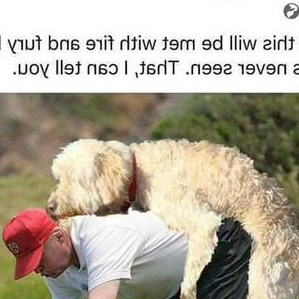

label: 1 



1113184475658293251
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.700e+01 4.000e+01 1.600e+01 1.070e+02 6.928e+03
 1.000e+00]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 3.8800e+02 8.0000e+01 2.2000e+01 5.4100e+02 1.7100e+02
 6.5000e+01 7.3000e+01 1.1000e+01 6.7000e+01 1.1150e+03 5.0000e+00
 1.1820e+03 2.2000e+01 4.5260e+03 1.0000e+01 2.8500e+02 

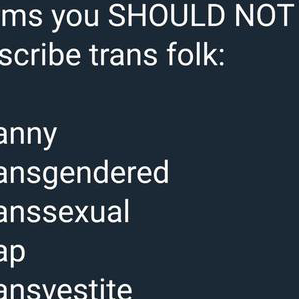

label: 1 





In [34]:
# test the data generator
X, ys = train_gen.__getitem__(0)
texts, img_texts, imgs = X
ids = train_gen.id_list[:32]

for ID, text, img_text, img, y in list(zip(ids, texts, img_texts, imgs, ys))[:3]:
    print(ID)
    print(text)
    print(img_text)
    img = Image.fromarray(np.uint8(img), 'RGB')
    display(img)
    print('label:', y, '\n\n\n')
